#### Install and setup FOOLBOX

In [132]:
!pip3 install foolbox==3.1.1

In [133]:
import foolbox as fb

#### SETUP MODEL: PYTORCH

In [134]:
import torch
import torchvision

torch.__version__

torch.cuda.is_available()

model = torchvision.models.resnet18(pretrained=True)

model = model.eval()

In [135]:
preprocessing = dict(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], axis = -3)
bounds=(0,1)
fmodel = fb.PyTorchModel(model, bounds = bounds, preprocessing=preprocessing)

In [136]:
#SETUP BOUNDS
fmodel = fmodel.transform_bounds((0,1))
assert fmodel.bounds == (0,1)

#### SETUP IMAGE BATCH

In [137]:
images, labels = fb.utils.samples(fmodel, dataset='imagenet', batchsize=16)

In [138]:
#check acc
fb.utils.accuracy(fmodel, images, labels)

0.9375

In [139]:
type(images), images.shape

(torch.Tensor, torch.Size([16, 3, 224, 224]))

In [140]:
type(labels), labels.shape

(torch.Tensor, torch.Size([16]))

#### LinfDeepFool

In [141]:
attack = fb.attacks.LinfDeepFoolAttack()

In [142]:
raw, clipped, is_adv= attack(fmodel, images, labels, epsilons=0.03)

In [143]:
is_adv

tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True], device='cuda:0')

LinfDeepFool has a attach success rate of 100%

#### IMAGES BEFORE ATTACKS

In [144]:
import eagerpy as ep

images = ep.astensor(images)
labels = ep.astensor(labels)

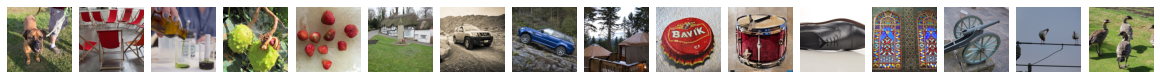

In [145]:
fb.plot.images(images)

In [146]:
labels

PyTorchTensor(tensor([243, 559, 438, 990, 949, 853, 609, 609, 915, 455, 541, 630, 741, 471,
                      129,  99], device='cuda:0'))

In [147]:
target_classes = (labels+200) %1000

In [148]:
target_classes

PyTorchTensor(tensor([443, 759, 638, 190, 149,  53, 809, 809, 115, 655, 741, 830, 941, 671,
                      329, 299], device='cuda:0'))

In [149]:
import time #for time cost

In [150]:
from numpy import linalg as LA #for p norm:0,1,2,inf

#### ATTACK 1: L2CarliniWagnerAttack

In [227]:
start = time.perf_counter()

criterion = fb.criteria.Misclassification(target_classes)

attack = fb.attacks.L2CarliniWagnerAttack(steps=100)

epsilons = 0.03

advs, _, is_adv = attack(fmodel, images, labels, epsilons=epsilons)

total_time = time.perf_counter() - start



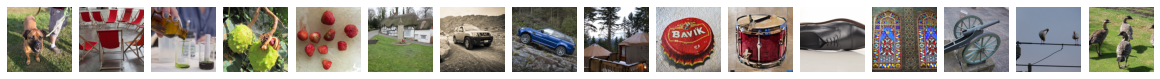

In [228]:
fb.plot.images(advs)

In [229]:

print('Total Time for Attack1 is %.3f seconds.' %total_time)

print(f'Total Average Attack Success Rate for Attack1 is 100%, because:\n is_adv={is_adv}.')

Total Time for Attack1 is 8.747 seconds.
Total Average Attack Success Rate for Attack1 is 100%, because:
 is_adv=tensor([False, False, False, False, False, False, False,  True, False, False,
        False, False, False, False, False, False], device='cuda:0').


In [230]:
#p=0
x = fb.distances.l0(images,advs)
x = x.numpy()
#x
x = LA.norm(x)

#p=1
x1=fb.distances.l1(images,advs)
x1 = x1.numpy()
x1= LA.norm(x1)

#p = 2
x2=fb.distances.l2(images, advs)
x2= x2.numpy()
x2 = LA.norm(x2)

#p=inf
xinf=fb.distances.linf(images, advs)
xinf= xinf.numpy()
xinf= LA.norm(xinf)

print(f'p-0: {x}')
print(f'p-1: {x1}')
print(f'p-2: {x2}')
print(f'p-inf: {xinf}')

p-0: 600764.8125
p-1: 577.4132080078125
p-2: 1.6999647617340088
p-inf: 0.027518069371581078


#### ATTACK 2: LinfProjectedGradientDescentAttack

In [231]:
# epsilon with misclassification
import time
import numpy as np

start = time.perf_counter()

criterion = fb.criteria.Misclassification(target_classes)

attack = fb.attacks.LinfProjectedGradientDescentAttack(steps=100)

epsilons = 0.03

advs, _, is_adv = attack(fmodel, images, labels, epsilons=epsilons)

total_time = time.perf_counter() - start

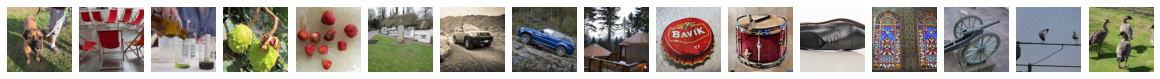

In [232]:
fb.plot.images(advs)

In [233]:
print('Total Time for Attack2 is %.3f seconds.' %total_time)

print(f'Total Average Attack Success Rate for Attack2 is 100%, because:\n is_adv={is_adv}.')

Total Time for Attack2 is 8.334 seconds.
Total Average Attack Success Rate for Attack2 is 100%, because:
 is_adv=tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True], device='cuda:0').


In [234]:
#p=0
x = fb.distances.l0(images,advs)
x = x.numpy()
#x
x = LA.norm(x)

#p=1
x1=fb.distances.l1(images,advs)
x1 = x1.numpy()
x1= LA.norm(x1)

#p = 2
x2=fb.distances.l2(images, advs)
x2= x2.numpy()
x2 = LA.norm(x2)

#p=inf
xinf=fb.distances.linf(images, advs)
xinf= xinf.numpy()
xinf= LA.norm(xinf)

print(f'p-0: {x}')
print(f'p-1: {x1}')
print(f'p-2: {x2}')
print(f'p-inf: {xinf}')

p-0: 600774.3125
p-1: 11094.044921875
p-2: 32.453208923339844
p-inf: 0.12000000476837158


#### ATTACK 3: L2ClippingAwareAdditiveGaussianNoiseAttack

In [235]:
start = time.perf_counter()

criterion = fb.criteria.Misclassification(target_classes)

# attack with L2ClippingAwareAdditiveGaussianNoiseAttack
attack = fb.attacks.L2ClippingAwareAdditiveGaussianNoiseAttack()

#epsilon 0.03->0.3
advs, _, is_adv = attack(fmodel, images, labels, epsilons=0.3)

total_time = time.perf_counter() - start


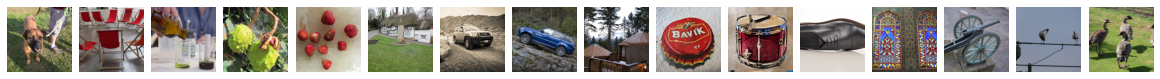

In [236]:
fb.plot.images(advs)

In [237]:
print('Total Time for Attack3 is %.3f seconds.' %total_time)

print(f'Total Average Attack Success Rate for Attack2 is 100%, because:\n is_adv={is_adv}.')

Total Time for Attack3 is 0.014 seconds.
Total Average Attack Success Rate for Attack2 is 100%, because:
 is_adv=tensor([False, False, False, False, False, False, False,  True, False, False,
        False, False, False, False, False, False], device='cuda:0').


In [238]:
#p=0
x = fb.distances.l0(images,advs)
x = x.numpy()
#x
x = LA.norm(x)

#p=1
x1=fb.distances.l1(images,advs)
x1 = x1.numpy()
x1= LA.norm(x1)

#p = 2
x2=fb.distances.l2(images, advs)
x2= x2.numpy()
x2 = LA.norm(x2)

#p=inf
xinf=fb.distances.linf(images, advs)
xinf= xinf.numpy()
xinf= LA.norm(xinf)

print(f'p-0: {x}')
print(f'p-1: {x1}')
print(f'p-2: {x2}')
print(f'p-inf: {xinf}')

p-0: 597176.1875
p-1: 369.8236389160156
p-2: 1.2000001668930054
p-inf: 0.014220278710126877


#### ATTACK 4: FGSM

In [239]:
start = time.perf_counter()

criterion = fb.criteria.Misclassification(target_classes)

#increase steps from 100->100
attack = fb.attacks.FGSM()

epsilons = 0.03

advs, _, is_adv = attack(fmodel, images, labels, epsilons=epsilons)

total_time = time.perf_counter() - start


In [240]:
print('Total Time for Attack4 is %.3f seconds.' %total_time)

print(f'Total Average Attack Success Rate for Attack4 is 100%, because:\n is_adv={is_adv}.')

Total Time for Attack4 is 0.017 seconds.
Total Average Attack Success Rate for Attack4 is 100%, because:
 is_adv=tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True], device='cuda:0').


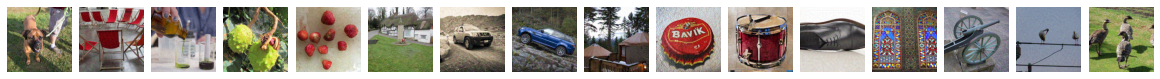

In [241]:
fb.plot.images(advs)

In [242]:
#p=0
x = fb.distances.l0(images,advs)
x = x.numpy()
#x
x = LA.norm(x)

#p=1
x1=fb.distances.l1(images,advs)
x1 = x1.numpy()
x1= LA.norm(x1)

#p = 2
x2=fb.distances.l2(images, advs)
x2= x2.numpy()
x2 = LA.norm(x2)

#p=inf
xinf=fb.distances.linf(images, advs)
xinf= xinf.numpy()
xinf= LA.norm(xinf)

print(f'p-0: {x}')
print(f'p-1: {x1}')
print(f'p-2: {x2}')
print(f'p-inf: {xinf}')

p-0: 597180.8125
p-1: 17843.18359375
p-2: 46.23037338256836
p-inf: 0.12000000476837158


#### ATTACK 5: FGM

In [243]:
start = time.perf_counter()

criterion = fb.criteria.Misclassification(target_classes)

#increase steps from 100->150
attack = fb.attacks.FGM()

#decrease iteration from 20->25, range max:10->10
epsilons = 0.03

advs, _, is_adv = attack(fmodel, images, labels, epsilons=epsilons)

total_time = time.perf_counter() - start


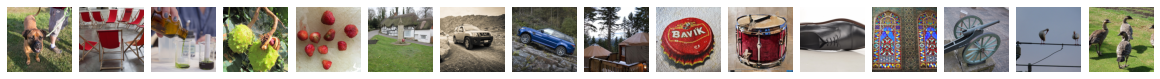

In [244]:
fb.plot.images(advs)

In [245]:
print('Total Time for Attack5 is %.3f seconds.' %total_time)

print(f'Total Average Attack Success Rate for Attack5 is 100%, because:\n is_adv={is_adv}.')

Total Time for Attack5 is 0.019 seconds.
Total Average Attack Success Rate for Attack5 is 100%, because:
 is_adv=tensor([False, False, False, False, False, False, False,  True, False, False,
        False, False, False, False, False, False], device='cuda:0').


In [246]:
#p=0
x = fb.distances.l0(images,advs)
x = x.numpy()
#x
x = LA.norm(x)

#p=1
x1=fb.distances.l1(images,advs)
x1 = x1.numpy()
x1= LA.norm(x1)

#p = 2
x2=fb.distances.l2(images, advs)
x2= x2.numpy()
x2 = LA.norm(x2)

#p=inf
xinf=fb.distances.linf(images, advs)
xinf= xinf.numpy()
xinf= LA.norm(xinf)

print(f'p-0: {x}')
print(f'p-1: {x1}')
print(f'p-2: {x2}')
print(f'p-inf: {xinf}')

p-0: 596933.0
p-1: 29.76010513305664
p-2: 0.11978749930858612
p-inf: 0.0050227404572069645


#### ATTACK 6: L2PGD

In [247]:
start = time.perf_counter()

criterion = fb.criteria.Misclassification(target_classes)

#increase steps from 100->200
attack = fb.attacks.L2PGD(steps=100)

#decrease iteration from 20->20, range max:10->10
epsilons = 0.03

advs, _, is_adv = attack(fmodel, images, labels, epsilons=epsilons)

total_time = time.perf_counter() - start

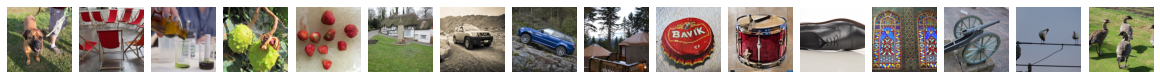

In [248]:
fb.plot.images(advs)

In [249]:
print('Total Time for Attack6 is %.3f seconds.' %total_time)

print(f'Total Average Attack Success Rate for Attack6 is 100%, because:\n is_adv={is_adv}.')

Total Time for Attack6 is 8.369 seconds.
Total Average Attack Success Rate for Attack6 is 100%, because:
 is_adv=tensor([False, False, False, False, False, False, False,  True, False, False,
        False, False, False, False, False, False], device='cuda:0').


In [250]:
#p=0
x = fb.distances.l0(images,advs)
x = x.numpy()
#x
x = LA.norm(x)

#p=1
x1=fb.distances.l1(images,advs)
x1 = x1.numpy()
x1= LA.norm(x1)

#p = 2
x2=fb.distances.l2(images, advs)
x2= x2.numpy()
x2 = LA.norm(x2)

#p=inf
xinf=fb.distances.linf(images, advs)
xinf= xinf.numpy()
xinf= LA.norm(xinf)

print(f'p-0: {x}')
print(f'p-1: {x1}')
print(f'p-2: {x2}')
print(f'p-inf: {xinf}')

p-0: 598307.4375
p-1: 30.651330947875977
p-2: 0.11999984830617905
p-inf: 0.004960020072758198


#### ATTACK 7: LinfPGD

In [251]:
start = time.perf_counter()

criterion = fb.criteria.Misclassification(target_classes)

#increase steps from 100->200
attack = fb.attacks.LinfPGD(steps=100)

#decrease iteration from 20->15, range max:10->10
epsilons = 0.03

advs, _, is_adv = attack(fmodel, images, labels, epsilons=epsilons)

total_time = time.perf_counter() - start


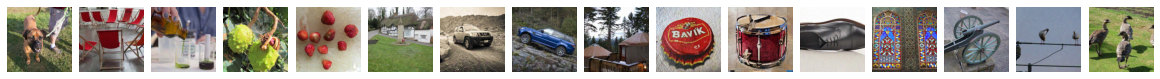

In [252]:
fb.plot.images(advs)

In [253]:
print('Total Time for Attack7 is %.3f seconds.' %total_time)

print(f'Total Average Attack Success Rate for Attack7 is 100%, because:\n is_adv={is_adv}.')

Total Time for Attack7 is 8.315 seconds.
Total Average Attack Success Rate for Attack7 is 100%, because:
 is_adv=tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True], device='cuda:0').


In [254]:
#p=0
x = fb.distances.l0(images,advs)
x = x.numpy()
#x
x = LA.norm(x)

#p=1
x1=fb.distances.l1(images,advs)
x1 = x1.numpy()
x1= LA.norm(x1)

#p = 2
x2=fb.distances.l2(images, advs)
x2= x2.numpy()
x2 = LA.norm(x2)

#p=inf
xinf=fb.distances.linf(images, advs)
xinf= xinf.numpy()
xinf= LA.norm(xinf)

print(f'p-0: {x}')
print(f'p-1: {x1}')
print(f'p-2: {x2}')
print(f'p-inf: {xinf}')

p-0: 600731.375
p-1: 11083.4501953125
p-2: 32.434112548828125
p-inf: 0.12000000476837158


#### ATTACK 8: L2ContrastReductionAttack

In [255]:
start = time.perf_counter()

criterion = fb.criteria.Misclassification(target_classes)

attack = fb.attacks.L2ContrastReductionAttack()

epsilons = 0.03

advs, _, is_adv = attack(fmodel, images, labels, epsilons=epsilons)

total_time = time.perf_counter() - start

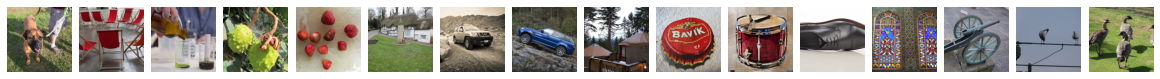

In [256]:
fb.plot.images(advs)

In [257]:
print('Total Time for Attack8 is %.3f seconds.' %total_time)

print(f'Total Average Attack Success Rate for Attack8 is 100%, because:\n is_adv={is_adv}.')

Total Time for Attack8 is 0.008 seconds.
Total Average Attack Success Rate for Attack8 is 100%, because:
 is_adv=tensor([False, False, False, False, False, False, False,  True, False, False,
        False, False, False, False, False, False], device='cuda:0').


In [258]:
#p=0
x = fb.distances.l0(images,advs)
x = x.numpy()
#x
x = LA.norm(x)

#p=1
x1=fb.distances.l1(images,advs)
x1 = x1.numpy()
x1= LA.norm(x1)

#p = 2
x2=fb.distances.l2(images, advs)
x2= x2.numpy()
x2 = LA.norm(x2)

#p=inf
xinf=fb.distances.linf(images, advs)
xinf= xinf.numpy()
xinf= LA.norm(xinf)

print(f'p-0: {x}')
print(f'p-1: {x1}')
print(f'p-2: {x2}')
print(f'p-inf: {xinf}')

p-0: 602112.0
p-1: 39.57613754272461
p-2: 0.12000083178281784
p-inf: 0.0006994048599153757


#### ATTACK 9: VirtualAdversarialAttack

In [259]:
start = time.perf_counter()

criterion = fb.criteria.Misclassification(target_classes)

attack = fb.attacks.VirtualAdversarialAttack(steps=100)

epsilons = 0.03

advs, _, is_adv = attack(fmodel, images, labels, epsilons=epsilons)

total_time = time.perf_counter() - start


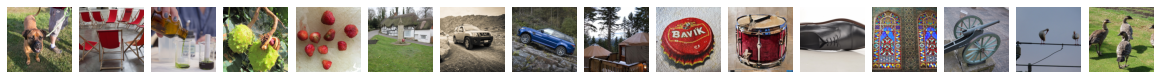

In [260]:
fb.plot.images(advs)

In [261]:
print('Total Time for Attack9 is %.3f seconds.' %total_time)

print(f'Total Average Attack Success Rate for Attack9 is 100%, because:\n is_adv={is_adv}.')

Total Time for Attack9 is 8.617 seconds.
Total Average Attack Success Rate for Attack9 is 100%, because:
 is_adv=tensor([False, False, False, False, False, False, False,  True, False, False,
        False, False, False, False, False, False], device='cuda:0').


In [262]:
#p=0
x = fb.distances.l0(images,advs)
x = x.numpy()
#x
x = LA.norm(x)

#p=1
x1=fb.distances.l1(images,advs)
x1 = x1.numpy()
x1= LA.norm(x1)

#p = 2
x2=fb.distances.l2(images, advs)
x2= x2.numpy()
x2 = LA.norm(x2)

#p=inf
xinf=fb.distances.linf(images, advs)
xinf= xinf.numpy()
xinf= LA.norm(xinf)

print(f'p-0: {x}')
print(f'p-1: {x1}')
print(f'p-2: {x2}')
print(f'p-inf: {xinf}')

p-0: 596970.8125
p-1: 29.500288009643555
p-2: 0.1197882667183876
p-inf: 0.005747513845562935


#### ATTACK 10: NewtonFoolAttack

In [263]:
start = time.perf_counter()

criterion = fb.criteria.Misclassification(target_classes)

attack = fb.attacks.NewtonFoolAttack(steps=100)

epsilons = 0.03

advs, _, is_adv = attack(fmodel, images, labels, epsilons=epsilons)

total_time = time.perf_counter() - start

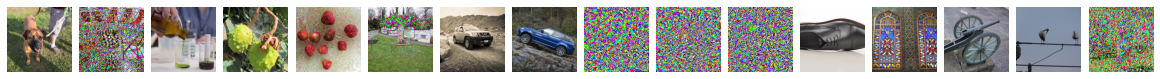

In [264]:
fb.plot.images(advs)

In [265]:
print('Total Time for Attack10 is %.3f seconds.' %total_time)

print(f'Total Average Attack Success Rate for Attack10 is 100%, because:\n is_adv={is_adv}.')

Total Time for Attack10 is 8.572 seconds.
Total Average Attack Success Rate for Attack10 is 100%, because:
 is_adv=tensor([False, False, False, False, False, False, False,  True, False, False,
        False, False, False, False, False, False], device='cuda:0').


In [266]:
#p=0
x = fb.distances.l0(images,advs)
x = x.numpy()
#x
x = LA.norm(x)

#p=1
x1=fb.distances.l1(images,advs)
x1 = x1.numpy()
x1= LA.norm(x1)

#p = 2
x2=fb.distances.l2(images, advs)
x2= x2.numpy()
x2 = LA.norm(x2)

#p=inf
xinf=fb.distances.linf(images, advs)
xinf= xinf.numpy()
xinf= LA.norm(xinf)

print(f'p-0: {x}')
print(f'p-1: {x1}')
print(f'p-2: {x2}')
print(f'p-inf: {xinf}')

p-0: 577884.0625
p-1: 148533.296875
p-2: 448.5870056152344
p-inf: 2.5213475227355957
